# Utilização do PyQGIS no Jupyter

### Webografia
* https://lerryws.xyz/posts/PyQGIS-in-Jupyter-Notebook
* https://github.com/3liz/qgis-nbextension/blob/master/examples/render_layer.py
* https://docs.qgis.org/testing/en/docs/pyqgis_developer_cookbook/

## PyQGIS no Jupyter

O QGIS permite ser utilizado a partir do Python, de acordo com a API [PyQGIS](https://docs.qgis.org/testing/en/docs/pyqgis_developer_cookbook/).

Neste notebook faz-se um pequeno exemplo dessa ligação, para se conseguir ter mapas num notebook, que são produzidos pelo QGIS. No fundo vamos ter um QGIS a correr em offline e que nos entrega o mapa como uma sequência de bytes.

### Ligação ao QGIS (standard)
Os paths específicos depende do sistema operativo e da forma como o QGIS foi instalado.

No caso geral, bastaria a seguinte inicialização:
```python
from osgeo import ogr
from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
```

Em Windows, a solução passa por instalar e arrancar o Jupyter no **ambiente Python do QGIS**. Pode-se fazer isso alterando a sccript `python-qgis.bat` em `OSGeo4W64\bin\`, acrescentando no fim:
```
pip install notebook
jupyter notebook --notebook-dir <diretoria do trabalho>
```

### Ligação ao QGIS (não standard)
Com o QGIS compilado localmente e instalado em `/usr/local`, como no caso seguinte, é preciso ajustar os caminhos para as bibliotecas Python. O exemplo seguinte é específico a um determinado ambiente, mas serve de inspiração para outros ambientes não standard, em que seja preciso ajustar caminhos.

In [1]:
import os
import sys
from osgeo import ogr
# os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/local/share/qgis/python')
from qgis.core import *
QgsApplication.setPrefixPath("/usr/local", True) 
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
# print(QgsApplication.showSettings())

#### Carregar uma camada a partir de uma tabela guardada num geopackage
Um geopackage pode conter vários layers. Associado ao layer pode estar associado um estilo predefinido, como no caso seguinte.

No exemplo, adiciona-se ao QGIS (que ainda não tem nenhuma camada), a camada `concelho`.

In [2]:
covid_gpkg = "covid-pt-latest.gpkg" + "|layername=concelho"
concelho = QgsVectorLayer(covid_gpkg, "Concelhos", "ogr")
if not concelho.isValid():
    print("Layer failed to load!")
else:
    QgsProject.instance().addMapLayer(concelho)
    print("Layer loaded")

Layer loaded


Percorrer as entidades da camada, e mostrar um atributo:

In [3]:
for c in concelho.getFeatures():
        print("Em {} há {} caso(s) confirmados".format(c["concelho"], c["confirmados_concelho_mais_recente"]))

Em ÁGUEDA há 44 caso(s) confirmados
Em ALBERGARIA-A-VELHA há 72 caso(s) confirmados
Em ANADIA há 36 caso(s) confirmados
Em AROUCA há 31 caso(s) confirmados
Em AVEIRO há 278 caso(s) confirmados
Em CASTELO DE PAIVA há 10 caso(s) confirmados
Em ESPINHO há 69 caso(s) confirmados
Em ESTARREJA há 60 caso(s) confirmados
Em SANTA MARIA DA FEIRA há 387 caso(s) confirmados
Em ÍLHAVO há 108 caso(s) confirmados
Em MEALHADA há 16 caso(s) confirmados
Em MURTOSA há 9 caso(s) confirmados
Em OLIVEIRA DE AZEMÉIS há 163 caso(s) confirmados
Em OLIVEIRA DO BAIRRO há 21 caso(s) confirmados
Em OVAR há 564 caso(s) confirmados
Em SÃO JOÃO DA MADEIRA há 57 caso(s) confirmados
Em SEVER DO VOUGA há 31 caso(s) confirmados
Em VAGOS há 18 caso(s) confirmados
Em VALE DE CAMBRA há 102 caso(s) confirmados
Em ALJUSTREL há NULL caso(s) confirmados
Em ALMODÔVAR há 3 caso(s) confirmados
Em ALVITO há NULL caso(s) confirmados
Em BARRANCOS há NULL caso(s) confirmados
Em BEJA há 9 caso(s) confirmados
Em CASTRO VERDE há NULL ca

Em vez de percorrer toda a camada, pode-se criar um filtro sobre a camada.

In [4]:
expr_sem_casos = QgsExpression( " \"confirmados_concelho_mais_recente\" IS NULL " )
virgens = list(concelho.getFeatures( QgsFeatureRequest( expr_sem_casos ) ))
for c in virgens:
        print("Em {} não há pelos menos 3 casos confirmados".format(c["concelho"]))

Em ALJUSTREL não há pelos menos 3 casos confirmados
Em ALVITO não há pelos menos 3 casos confirmados
Em BARRANCOS não há pelos menos 3 casos confirmados
Em CASTRO VERDE não há pelos menos 3 casos confirmados
Em FERREIRA DO ALENTEJO não há pelos menos 3 casos confirmados
Em MÉRTOLA não há pelos menos 3 casos confirmados
Em OURIQUE não há pelos menos 3 casos confirmados
Em VIDIGUEIRA não há pelos menos 3 casos confirmados
Em FREIXO DE ESPADA À CINTA não há pelos menos 3 casos confirmados
Em BELMONTE não há pelos menos 3 casos confirmados
Em IDANHA-A-NOVA não há pelos menos 3 casos confirmados
Em OLEIROS não há pelos menos 3 casos confirmados
Em PENAMACOR não há pelos menos 3 casos confirmados
Em PROENÇA-A-NOVA não há pelos menos 3 casos confirmados
Em VILA DE REI não há pelos menos 3 casos confirmados
Em VILA VELHA DE RÓDÃO não há pelos menos 3 casos confirmados
Em PAMPILHOSA DA SERRA não há pelos menos 3 casos confirmados
Em ALANDROAL não há pelos menos 3 casos confirmados
Em ARRAIOLOS 

A geração do mapa tem algumas questões técnicas. O melhor seria encapsular estas questões numa função. Fica o desafio.

In [5]:
xt = concelho.extent()
# print(xt)
width  = 200
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([concelho])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 200 por 409


In [6]:
from IPython.display import Image

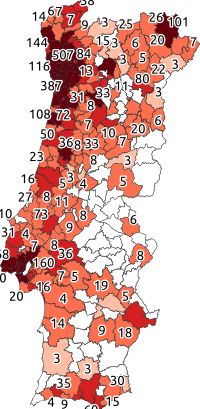

In [7]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

Se se quizer fechar a instância do QGIS que está a correr, termina-se com:

In [8]:
qgs.exitQgis()